## experiment state manager


In [1]:
from typing import Literal, Callable, Self

import numpy as np
from numpy.typing import NDArray
from numpy.random import RandomState, MT19937, SeedSequence


class POPOPState:
    POPULATION_VARY_METHODS = ("uniform_crossover",)
    INDIVIDUALS_SELECTION_METHODS = ("tournament", "truncation", "proportional")

    def __init__(
        self,
        individual_size: int,
        population_size: int,
        population_vary_method: Literal["uniform_crossover"],
        population_vary_probability_threshold: float,
        individual_selection_method: Literal[
            "tournament", "truncation", "proportional"
        ],
        fitness_fn: Callable[[NDArray[np.uint8]], int],
        max_evaluations: int,
        tournament_size: int = 2,
        truncation_size: int | None = None,
        proportional_size: int | None = None,
        random_seed: int | None = None,
    ):
        if population_vary_method not in self.POPULATION_VARY_METHODS:
            raise ValueError(
                f"`population_vary_method`={population_vary_method} does not exists or is yet to be implemented."
            )

        if individual_selection_method not in self.INDIVIDUALS_SELECTION_METHODS:
            raise ValueError(
                f"`individual_selection_method`={individual_selection_method} does not exists or is yet to be implemented."
            )

        if individual_selection_method == "truncation" and truncation_size is None:
            truncation_size = population_size

        if individual_selection_method == "proportional" and proportional_size is None:
            proportional_size = population_size

        self._random_state = RandomState(MT19937(SeedSequence(random_seed)))
        self._individual_size = individual_size
        self._population_size = population_size
        self._population_vary_method = population_vary_method
        self._population_vary_probability_threshold = (
            population_vary_probability_threshold
        )
        self._individual_selection_method = individual_selection_method
        self._tournament_size = tournament_size
        self._truncation_size = truncation_size
        self._proportional_size = proportional_size
        self._fitness_fn = fitness_fn
        self._max_evaluations = max_evaluations
        self._current_evaluations = population_size
        self._population: NDArray[np.uint8] | None = None
        self._offsprings: NDArray[np.uint8] | None = None
        self._best_fitnesses: list[int] = []
        self._best_fitness_evaluations: list[int] = []

    def fitness_fn(self, individual: NDArray[np.uint8], update_evaluations: bool):
        if update_evaluations:
            self._current_evaluations += 1
        return self._fitness_fn(individual)

    def initialize_population(self) -> Self:
        self._population = self._random_state.randint(
            low=0,
            high=2,
            size=(self._population_size, self._individual_size),
            dtype=np.uint8,
        )
        best_fitness = max(
            self.fitness_fn(x, update_evaluations=True) for x in self._population
        )
        self._update_best_fitnesses(best_fitness)
        return self

    def generate_offsprings(self) -> Self:
        if self._population is None:
            raise ValueError(
                "population has to be initialize with method `initialize_population` in order to generate offsprings."
            )

        if self._population_vary_method == "uniform_crossover":
            shuffled_popluation_indices = np.arange(self._population_size).tolist()
            self._random_state.shuffle(shuffled_popluation_indices)

            offsprings: list[list[int]] = []

            random_state_rand = self._random_state.rand
            for i in range(0, self._population_size, 2):
                offspring0_index = shuffled_popluation_indices[i]
                offspring1_index = shuffled_popluation_indices[i + 1]
                offspring0 = self._population[offspring0_index].tolist()
                offspring1 = self._population[offspring1_index].tolist()

                for parameter_index in range(0, self._individual_size):
                    crossover_probabiliy = random_state_rand()
                    if (
                        crossover_probabiliy
                        < self._population_vary_probability_threshold
                    ):
                        offspring0[parameter_index], offspring1[parameter_index] = (
                            offspring1[parameter_index],
                            offspring0[parameter_index],
                        )

                offsprings.extend((offspring0, offspring1))

            self._offsprings = np.array(offsprings, dtype=np.uint8)

        return self

    def _update_best_fitnesses(self, best_fitness: int):
        self._best_fitnesses.append(best_fitness)
        self._best_fitness_evaluations.append(self._current_evaluations)

    def _evaluate_individuals_pool(self):
        assert self._population is not None
        assert self._offsprings is not None

        fitness_fn = self.fitness_fn

        population_fitnesses = np.array(
            [fitness_fn(x, update_evaluations=False) for x in self._population],
            dtype=np.uint,
        )
        offspring_fitnesses = np.array(
            [fitness_fn(x, update_evaluations=True) for x in self._offsprings],
            dtype=np.uint,
        )

        individuals_pool = np.concatenate((self._population, self._offsprings), axis=0)
        individual_fitnesses = np.concatenate(
            (population_fitnesses, offspring_fitnesses), axis=0
        )

        return individuals_pool, individual_fitnesses

    def _tournament_select(self):
        individuals_pool, individual_fitnesses = self._evaluate_individuals_pool()

        selection_indices: list[int] = []
        shuffled_individuals_pool_indices = np.arange(
            0, individuals_pool.shape[0], dtype=np.uint
        )

        random_state_shuffle = self._random_state.shuffle
        selection_indices_append = selection_indices.append
        while len(selection_indices) < self._population_size:
            random_state_shuffle(shuffled_individuals_pool_indices)

            for i in range(0, individuals_pool.shape[0], self._tournament_size):
                argmax_tournament_i = np.argmax(
                    individual_fitnesses[
                        shuffled_individuals_pool_indices[i : i + self._tournament_size]
                    ]
                )

                selection_indices_append(
                    shuffled_individuals_pool_indices[i + argmax_tournament_i]
                )

        selection_indices = selection_indices[: self._population_size]

        best_fitness = np.max(individual_fitnesses[selection_indices])
        self._update_best_fitnesses(int(best_fitness))

        return individuals_pool[selection_indices]

    def _truncation_select(self):
        individuals_pool, individual_fitnesses = self._evaluate_individuals_pool()

        assert self._truncation_size is not None
        selected_indices = np.argsort(individual_fitnesses)[-self._truncation_size :]

        best_fitness = np.max(individual_fitnesses[selected_indices])
        self._update_best_fitnesses(int(best_fitness))

        return individuals_pool[selected_indices]

    def _proportional_select(self):
        individuals_pool, individual_fitnesses = self._evaluate_individuals_pool()

        total_fitness = sum(individual_fitnesses)
        individual_selection_probabilities = (
            np.array(individual_fitnesses) / total_fitness
        )

        individual_cumulative_selection_probabilities = np.cumsum(
            individual_selection_probabilities
        )
        assert self._proportional_size is not None
        selected_indices = [0 for _ in range(self._proportional_size)]

        rand = self._random_state.rand
        searchsorted = np.searchsorted
        for i in range(self._proportional_size):
            selection_probabilty = rand()
            individual_index = searchsorted(
                individual_cumulative_selection_probabilities,
                selection_probabilty,
                side="right",
            )
            selected_indices[i] = int(individual_index)

        best_fitness = np.max(individual_fitnesses[selected_indices])
        self._update_best_fitnesses(int(best_fitness))

        return individuals_pool[selected_indices]

    def select_elite_individuals(self) -> Self:
        if self._individual_selection_method == "tournament":
            elites = self._tournament_select()
            self._population = elites
            return self

        if self._individual_selection_method == "truncation":
            elites = self._truncation_select()
            self._population = elites
            return self

        if self._individual_selection_method == "proportional":
            elites = self._proportional_select()
            self._population = elites
            return self

        raise NotImplementedError(
            f"selection methods have been declared in `{self.__class__.__name__}` but have yet to be implemented, this is a library development error, not an user usage one."
        )

    @property
    def best_fitnesses(self):
        if len(self._best_fitnesses) == 0:
            raise ValueError(
                "no evaluation has yet to be run, therefore no `best_fitnesses` exists."
            )
        return np.array(self._best_fitnesses, dtype=np.uint)

    @property
    def best_fitness_evaluations(self):
        if len(self._best_fitness_evaluations) == 0:
            raise ValueError(
                "no evaluation has yet to be run, therefore no `best_fitness_evaluations` exists."
            )
        return np.array(self._best_fitness_evaluations, dtype=np.uint)

    @property
    def reached_max_evaluations(self):
        return self._current_evaluations >= self._max_evaluations

    @property
    def individual_size(self):
        return self._individual_size

    @property
    def population_size(self):
        return self._population_size

    @property
    def max_evaluations(self):
        return self._max_evaluations

## fitness functions


In [2]:
import numpy as np
from numpy.typing import NDArray


def onemax(individual: NDArray[np.uint8]):
    if individual.ndim != 1:
        raise ValueError(
            f"individual has `ndim`={individual.ndim} while it needs to be 1."
        )

    return np.sum(individual, dtype=np.uint).tolist()


def leading_one(individual: NDArray[np.uint8]):
    if individual.ndim != 1:
        raise ValueError(
            f"individual has `ndim`={individual.ndim} while it needs to be 1."
        )

    count = 0
    for bit in individual:
        bit = int(bit)
        if bit != 1:
            break
        count += 1
    return count


def concatenated_trap_5(individual: NDArray[np.uint8]):
    if individual.ndim != 1:
        raise ValueError(
            f"individual has `ndim`={individual.ndim} while it needs to be 1."
        )

    if individual.shape[0] % 5 != 0:
        raise ValueError(
            f"individual size is {individual.shape[0]} indivisible by 5, which is required to perform `concatenated_trap_5` benchmark"
        )

    fitness = 0

    for i in range(0, individual.shape[0], 5):
        enabled_parameters_count = 0

        for section_i in range(0, 5):
            if int(individual[i + section_i]) == 1:
                enabled_parameters_count += 1

        if enabled_parameters_count == 5:
            enabled_parameters_count = 5
            fitness += enabled_parameters_count
            continue

        enabled_parameters_count = 4 - enabled_parameters_count
        fitness += enabled_parameters_count

    return fitness

In [3]:
import numpy as np
from typing import Callable, Literal
from numpy.typing import NDArray


def pipelines(
    fitness_fn: Callable[[NDArray[np.uint8]], int],
    individual_size: int,
    population_size: int,
    individual_selection_method: Literal["tournament", "truncation", "proportional"],
    max_evaluations: int,
    student_id: int = 22520278,
):
    for random_seed in range(student_id, student_id + 10):
        state = POPOPState(
            individual_size=individual_size,
            population_size=population_size,
            population_vary_method="uniform_crossover",
            population_vary_probability_threshold=0.5,
            individual_selection_method=individual_selection_method,
            tournament_size=4,
            fitness_fn=fitness_fn,
            max_evaluations=max_evaluations,
            random_seed=random_seed,
        ).initialize_population()

        while not state.reached_max_evaluations:
            state = state.generate_offsprings().select_elite_individuals()

        yield state

## plotting function


In [4]:
import numpy as np
from typing import Iterable, Literal
from matplotlib.axes import Axes


def plot_from_states(
    states: Iterable[POPOPState],
    selection_method: Literal["tournament", "truncation", "proportional"],
    title: str,
    color: str,
    ax: Axes,
):
    fits: list[NDArray[np.uint]] = []
    evaluations: NDArray[np.uint] | None = None
    max_evaluations: int | None = None
    population_size: int | None = None
    individual_size: int | None = None

    for state in states:
        if evaluations is None:
            evaluations = state.best_fitness_evaluations

        if max_evaluations is None:
            max_evaluations = state.max_evaluations

        if population_size is None:
            population_size = state.population_size

        if individual_size is None:
            individual_size = state.individual_size

        best_fitnesses = state.best_fitnesses
        fits.append(best_fitnesses)

    fits_array = np.vstack(fits)

    average: NDArray[np.float64] = np.mean(fits_array, axis=0, dtype=np.float64)
    error: NDArray[np.float64] = np.std(fits_array, axis=0, dtype=np.float64)

    assert evaluations is not None
    assert max_evaluations is not None
    assert population_size is not None
    assert individual_size is not None

    ax.plot(evaluations, average, label=selection_method, color=color)  # type: ignore
    ax.fill_between(  # type: ignore
        evaluations, average + error, average - error, facecolor=color, alpha=0.1
    )
    ax.set_xlabel("evaluations")  # type: ignore
    ax.set_ylabel("fitness")  # type: ignore
    ax.set_xlim(0, max_evaluations + population_size)  # type: ignore
    ax.set_ylim(0, individual_size + individual_size // 10 + individual_size % 10)  # type: ignore

    ax.set_title(title)  # type: ignore
    ax.legend()  # type: ignore
    ax.grid()  # type: ignore

## experiments


In [5]:
from typing import Literal
from matplotlib import pyplot as plt


def experiment_on(
    benchmark: Literal["onemax", "leading_one", "concatenated_trap_5"],
    *population_sizes: int,
    max_evaluations: int = 10_000,
):
    BENCHMARKS = ("onemax", "leading_one", "concatenated_trap_5")
    if benchmark not in BENCHMARKS:
        raise NotImplementedError(
            f"`benchmark`={benchmark} does not exist or is yet to be implemented."
        )

    nrows = len(population_sizes) // 3 + (0 if len(population_sizes) % 3 == 0 else 1)
    ncols = 3
    figure = plt.figure(figsize=(8 * ncols, 5 * nrows), layout="tight")  # type: ignore

    if benchmark == "onemax":
        for i, population_size in enumerate(population_sizes, start=1):
            ax = figure.add_subplot(nrows, ncols, i)  # type: ignore
            for color, individual_selection_method in zip(
                ("r", "g", "b"), ("tournament", "truncation", "proportional")
            ):
                plot_from_states(
                    pipelines(
                        fitness_fn=onemax,
                        individual_size=100,
                        population_size=population_size,
                        individual_selection_method=individual_selection_method,
                        max_evaluations=max_evaluations,
                    ),
                    selection_method=individual_selection_method,
                    title=f"onemax on 100 dimensions with population size of {population_size}",
                    color=color,
                    ax=ax,
                )
        return

    if benchmark == "leading_one":
        for i, population_size in enumerate(population_sizes, start=1):
            ax = figure.add_subplot(nrows, ncols, i)  # type: ignore
            for color, individual_selection_method in zip(
                ("r", "g", "b"), ("tournament", "truncation", "proportional")
            ):
                plot_from_states(
                    pipelines(
                        fitness_fn=leading_one,
                        individual_size=20,
                        population_size=population_size,
                        individual_selection_method=individual_selection_method,
                        max_evaluations=max_evaluations,
                    ),
                    selection_method=individual_selection_method,
                    title=f"leading one on 20 dimensions with population size of {population_size}",
                    color=color,
                    ax=ax,
                )
        return

    if benchmark == "concatenated_trap_5":
        for i, population_size in enumerate(population_sizes, start=1):
            ax = figure.add_subplot(nrows, ncols, i)  # type: ignore
            for color, individual_selection_method in zip(
                ("r", "g", "b"), ("tournament", "truncation", "proportional")
            ):
                plot_from_states(
                    pipelines(
                        fitness_fn=concatenated_trap_5,
                        individual_size=25,
                        population_size=population_size,
                        individual_selection_method=individual_selection_method,
                        max_evaluations=max_evaluations,
                    ),
                    selection_method=individual_selection_method,
                    title=f"concatenated trap 5 on 25 dimensions with population size of {population_size}",
                    color=color,
                    ax=ax,
                )
        return

### onemax on 100 dimensions


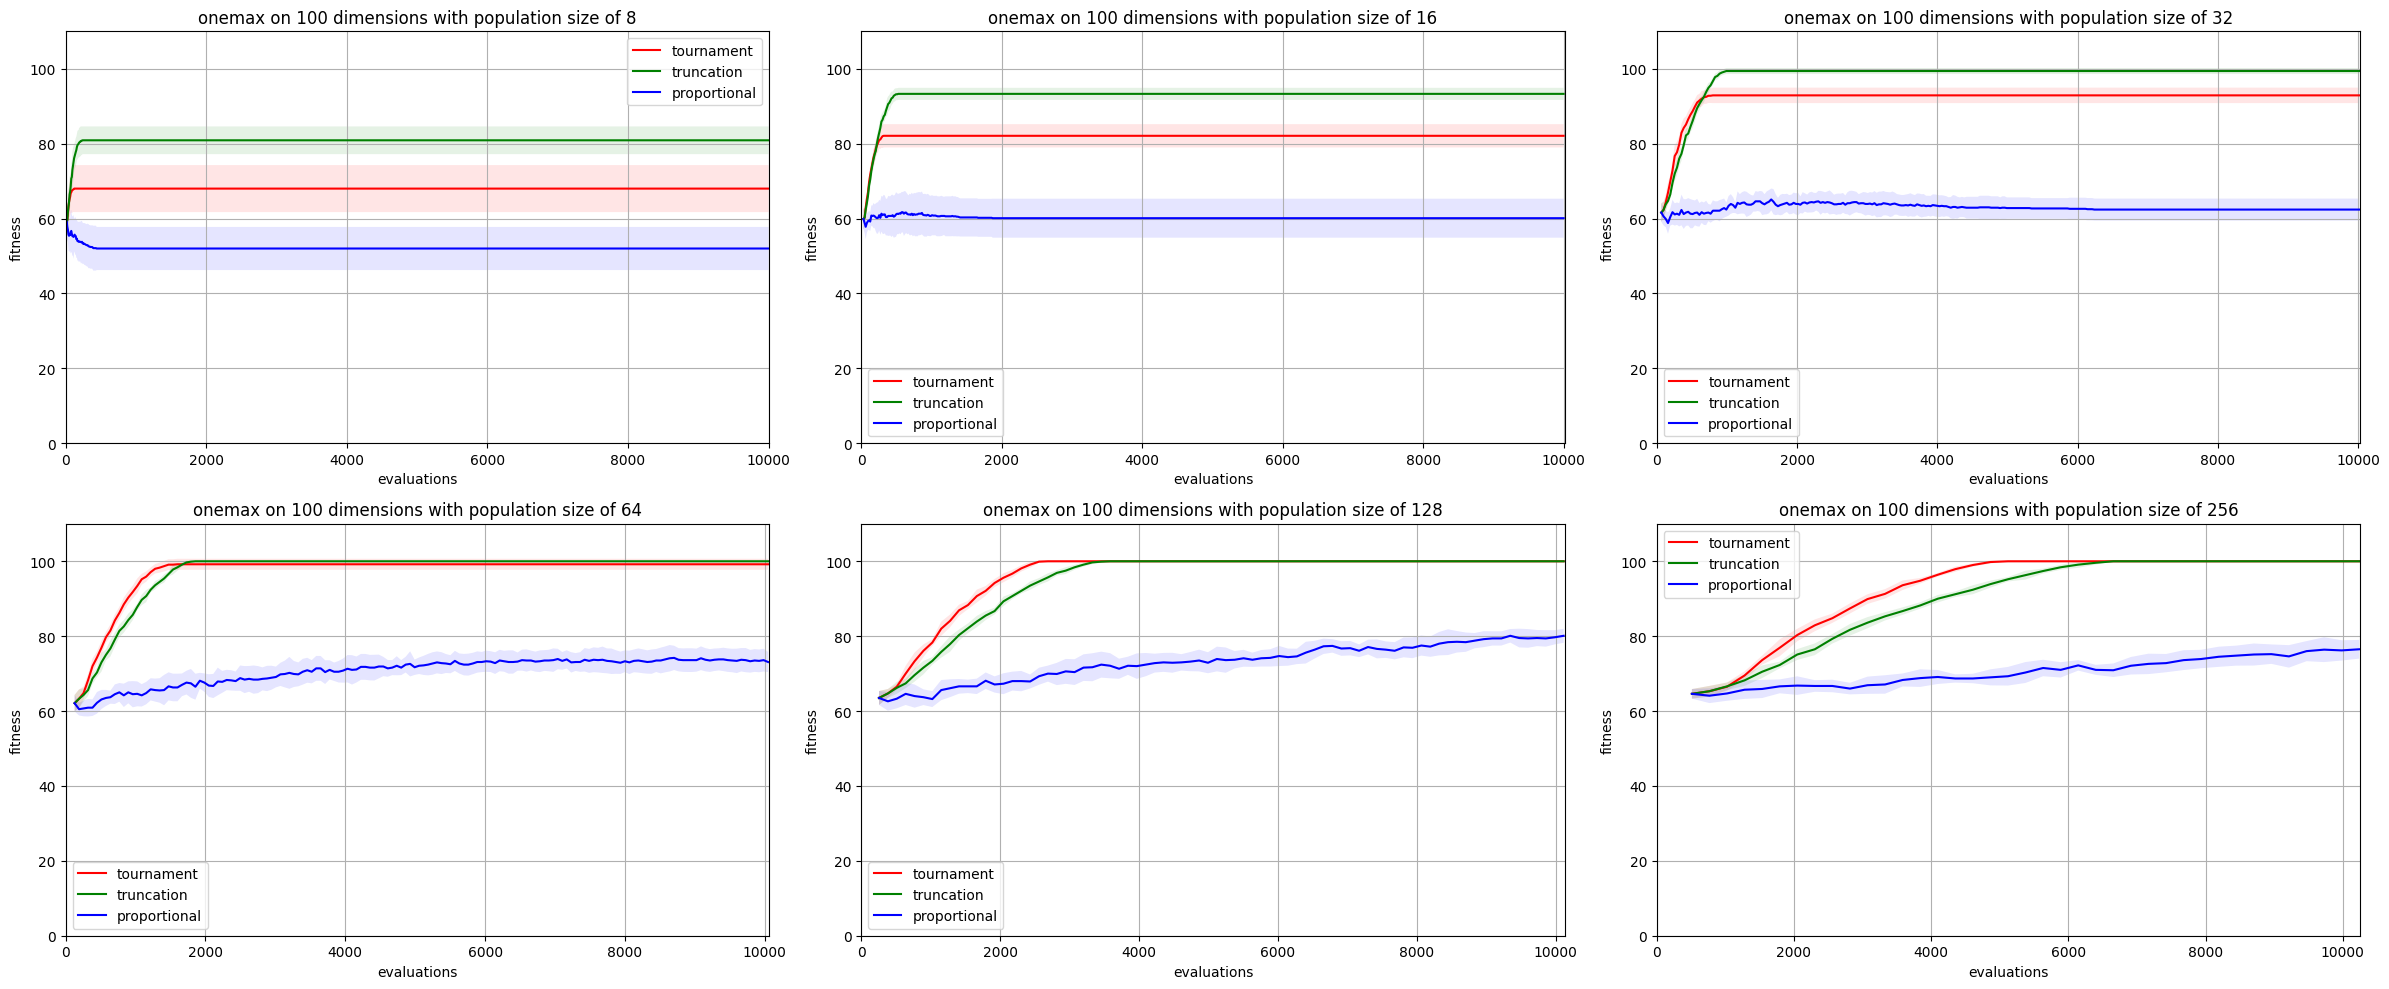

In [6]:
experiment_on("onemax", *(2**i for i in range(3, 3 + 6)))

### leading one on 20 dimensions


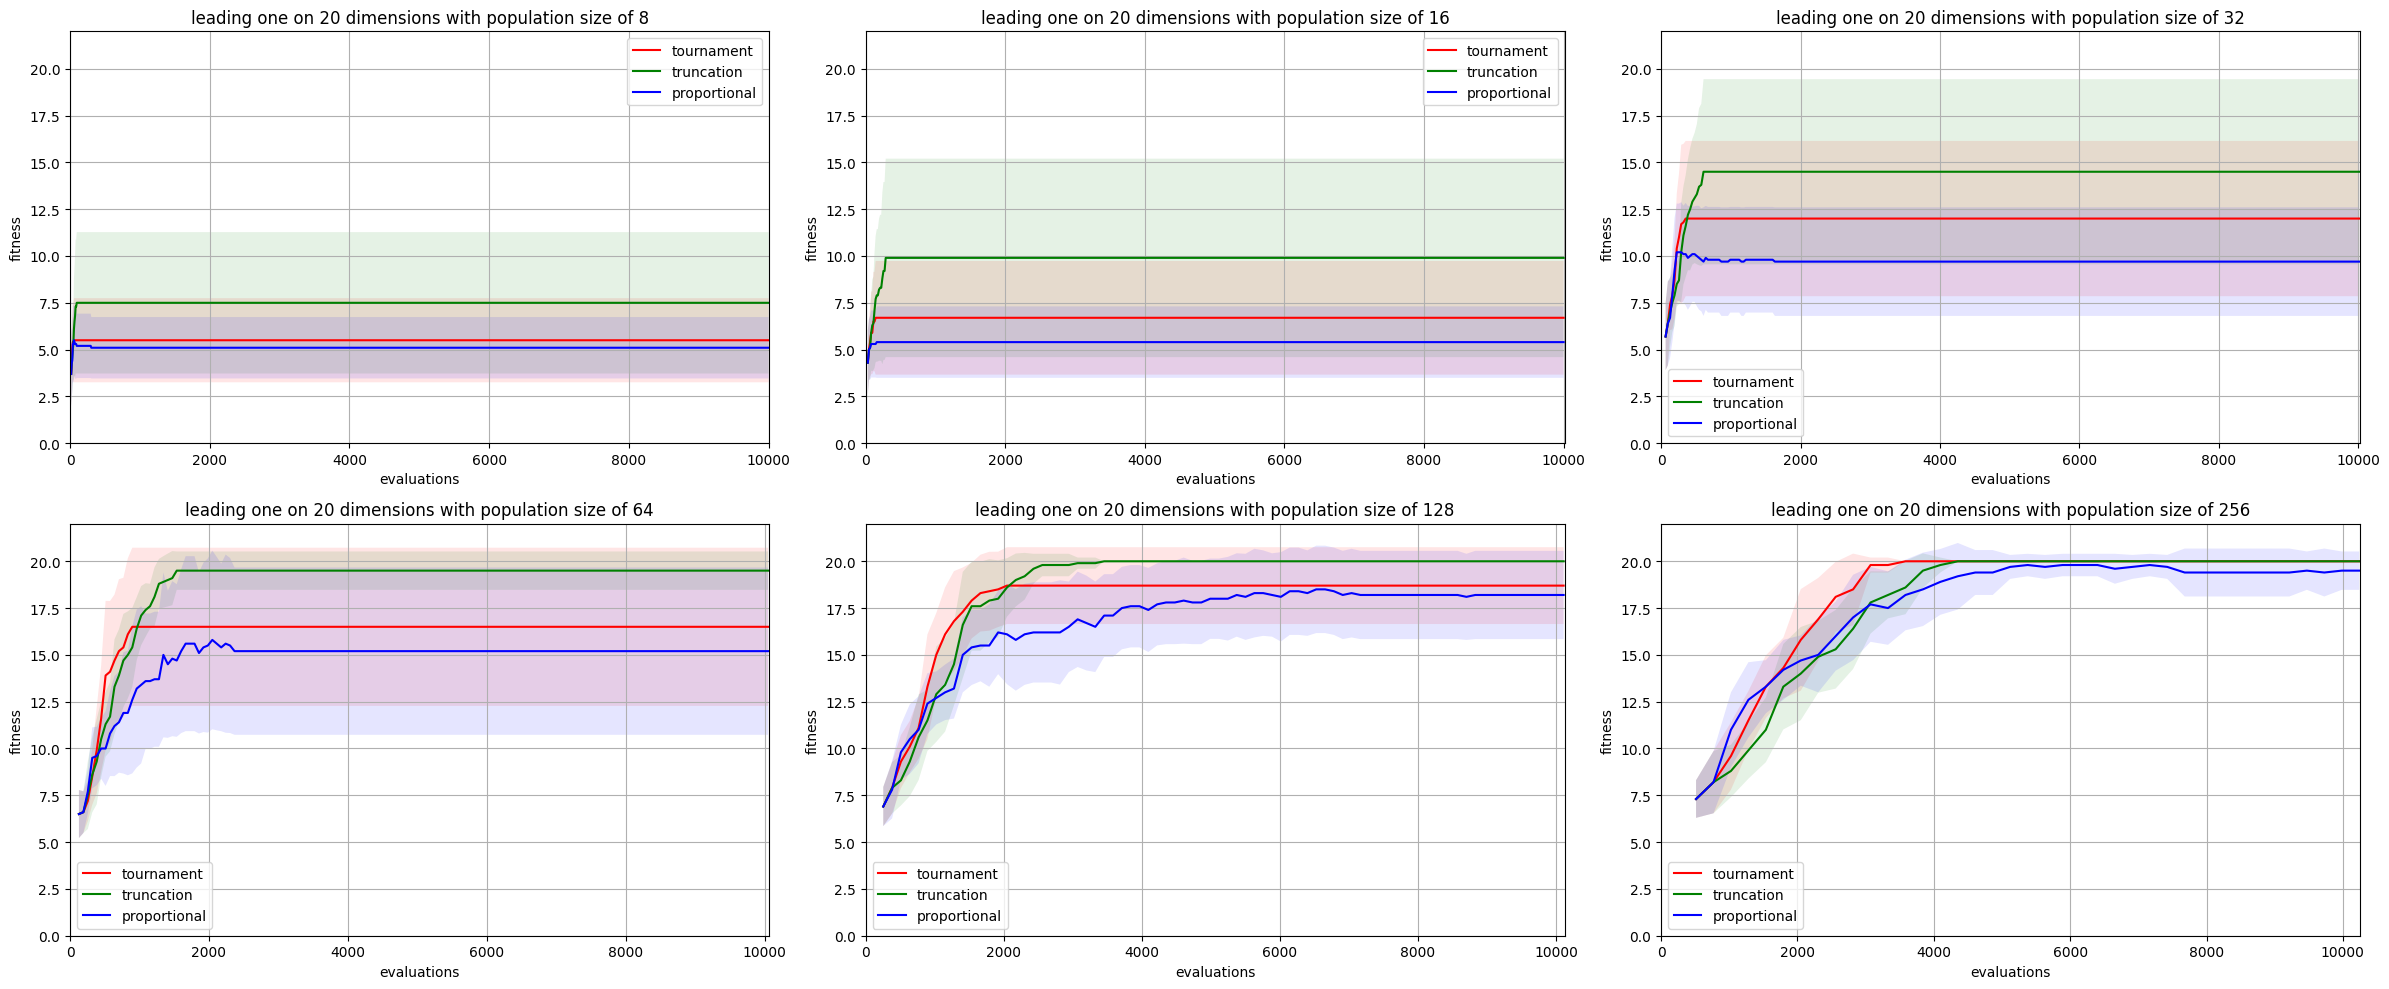

In [7]:
experiment_on("leading_one", *(2**i for i in range(3, 3 + 6)))

### concatenated trap 5 on 25 dimensions


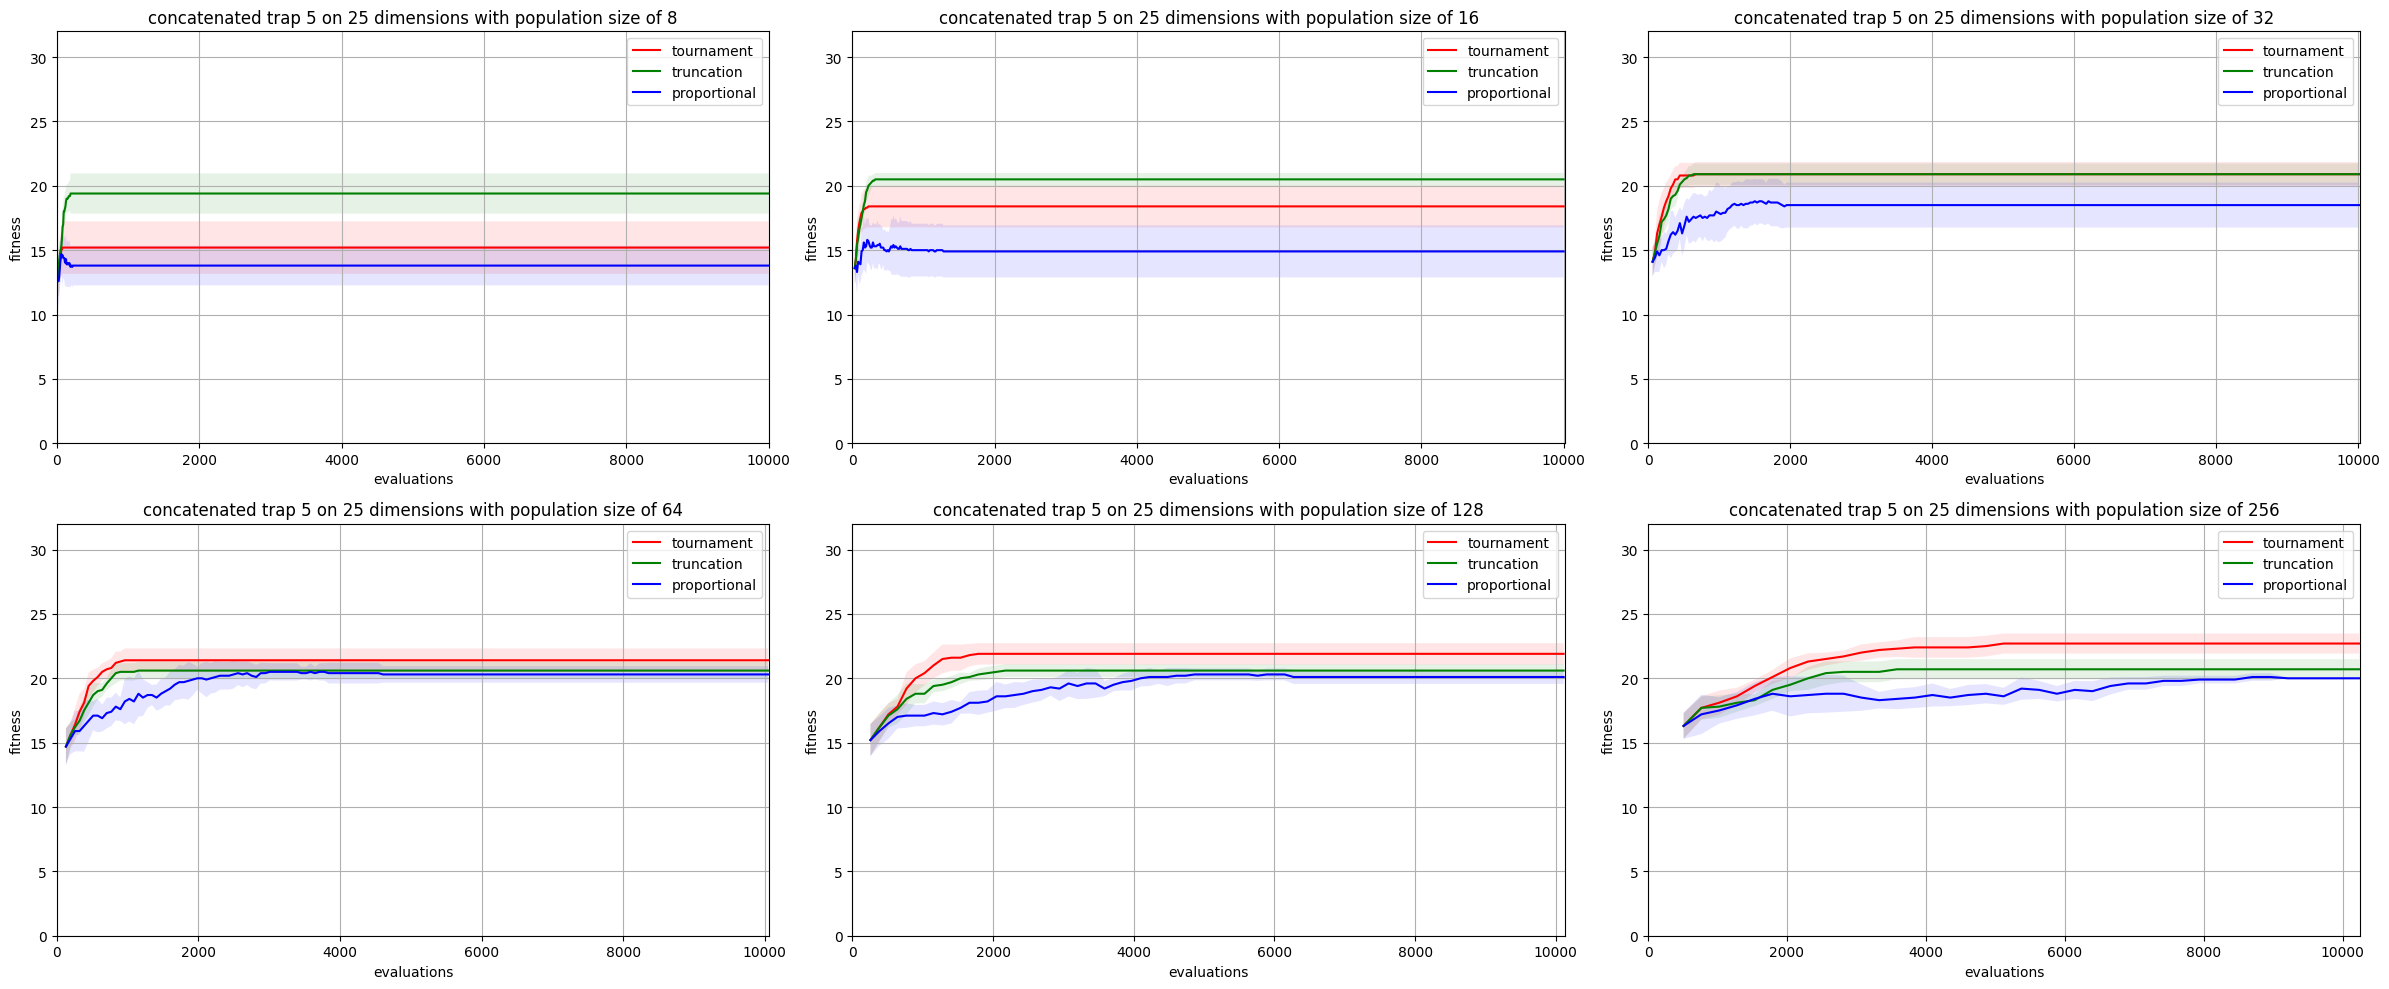

In [8]:
experiment_on("concatenated_trap_5", *(2**i for i in range(3, 3 + 6)))

## conclusions


- tournament selection performed best across all test cases. it is consistent and show robustness on convergency in comparison with the other two methods.
- truncation selection held its place against tournament selection. it sometimes lags behind but still mostly matches the perfomance of the latter, particularly in deterministic problems such as onemax.
- proportional selection struggles obviously with all three benchmarks. it converges slowly, find difficulties in improvement over time and has higher variance in results.
- as population size increases, all methods benefit, but the performance gap between compared methods still persits. for small populations, stochastic effects cause more fluctuations.
- with onemax benchmark:
  - tournament and truncation selection methods both reach optimal fitness quickly, while proportional falls behind.
- with leading one benchmark:
  - truncation performs well but exhibits higher variance, while tournament maintains robustness. proportional selection again struggles.
- with concatenated trap benchmark:
  - the most challenging, most trivial fitness gain benchmark function. tournament selection remains the best but the performance gap narrows with increasing population size.

in brief, tournament selection is the most performative and efficient of the three. truncation selection is a viable alternative but introduces a slightly higher variance. proportional selection is unreliable and unfit for effective optimization in these evolutionary algorithms.